# Di-lepton analysis

### Introduction

This notebook is used to process the data stored in [NANOAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) format, and select candidate events of exclusive dilepton production, $pp\to p\oplus\ell\ell\oplus p$, with $\ell\in\{ e,\mu,\tau \} $. Feynman diagram of this process is shown bellow: 

<img src="img/diagrams.png" alt="Feynman diagrams" width="800">



This notebook was prepared based on the [df102_NanoAODDimuonAnalysis.py](https://root.cern.ch/doc/master/group__tutorial__dataframe.html) example from ROOT.

In [1]:
%env analysis_num=2

env: analysis_num=2


In [2]:
%%bash
rm -rf results && mkdir results

In [3]:
import ROOT
 
# Enable multi-threading
ROOT.ROOT.EnableImplicitMT()

#include auxiliary functions from C++ header
ROOT.gInterpreter.Declare('#include "SelectorTools.h"')

Welcome to JupyROOT 6.25/01


True

In [4]:
%%bash
rootls -l root://eoscms.cern.ch///eos/cms/store/data/Run2018D/DoubleMuon/NANOAOD/UL2018_MiniAODv1_NanoAODv2-v1/270000/86755BE1-4E62-7B48-8E78-7A97D41871D4.root

TTree       Dec 14 17:13 2020 Events;1           "Events" 
TTree       Dec 14 17:13 2020 LuminosityBlocks;1 "LuminosityBlocks" 
TTree       Dec 14 17:13 2020 MetaData;1         "Job metadata" 
TTree       Dec 14 17:13 2020 ParameterSets;1    "Parameter sets" 
TTree       Dec 14 17:13 2020 Runs;1             "Runs" 
TObjString  Dec 14 16:12 2020 tag;1              "Collectable string class" 


In [5]:
# ./init.sh

In [6]:
# echo $AWS_CREDENTIALS

In [7]:
%%bash
mkdir -p ~/.aws && cat <<EOF > ~/.aws/credentials
EOF

In [8]:
#AWS_CREDENTIALS > ~/.aws/credentials

### Datasets
`Datasets.py` contains the list of datasets that can be used in the analysis. The `listDatasets()` command will print out the complete list of datasets and also information about samples availability on EOS. 

In [9]:
from Datasets import *
listDatasets()

The following datasets are available:
/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-Pilot_106X_upgrade2018_realistic_v15_L1v1-v2/NANOAODSIM (No directories available in EOS for this dataset)
/DYToMuMu_pomflux_Pt-30_TuneCP5_13TeV-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM (No directories available in EOS for this dataset)
/SingleMuon/Run2017A-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/N

### Analysis

Measurement of exclusive production of lepton pairs rely on two selections:
1. Exclusive cuts - leptons are produced exclusively, i.e., no other particles produced during the proton-proton interaction
2. Correlation between leptons and protons: Due to energy-momentum conservation, the following equation holds:
$ \xi_\pm = \frac{1}{\sqrt{s}}\left[ p_{T,\ell1}\cdot e^{\pm\eta_{\ell1}} + p_{T,\ell2}\cdot e^{\pm\eta_{\ell2}} \right] $, where $\xi$ is proton momentum loss, and $\pm$ sign related to $\xi$ reconstruction of positive/negative proton.

The analysis strategy is to apply selection cuts as in (1) and then plot the difference between $\xi$ reconstructed from leptons and $\xi$ measured by PPS. The events where di-lepton kinematics agree with proton kinematics will be candidates for exclusive dilepton production.

---
Proton content is not available in MC yet, so here we will analyze the data, searching for the correlation between measured $\xi$ from the proton and the predicted $\xi$ based on the lepton kinematics. We are using data available on EOS to speed up the analysis. 

For the example, we will process a small amount of data:

In [10]:
#Select which datasets to use
datasets=[
    'Run2018A_DoubleMuon',
    'Run2018B_DoubleMuon',
    'Run2018C_DoubleMuon',
    'Run2018D_DoubleMuon',
]

In [11]:
#Create a list of files to analyze
for ds in datasets:
    listFiles=getFilesForDataset(ds)
files = ROOT.std.vector("string")(len(listFiles))
for i,f in enumerate(listFiles):
    files[i]=f  
print('found %d files'%len(files))

found 0 files


In [12]:
# files=[
#     'root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/02466EF4-1D3E-BF4C-B43F-0DCC7C61BCC2.root' 
# #     'root://cms-xrd-global.cern.ch///eos/cms/store/data/Run2018D/DoubleMuon/NANOAOD/UL2018_MiniAODv1_NanoAODv2-v1/270000/86755BE1-4E62-7B48-8E78-7A97D41871D4.root' 
# ]

In [13]:
files =[
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/02466EF4-1D3E-BF4C-B43F-0DCC7C61BCC2.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/05F131DC-3124-8840-93DE-BF3133552488.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/0A439D00-3AD6-534B-9B2D-2C25A5587B47.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/0B7C8114-450F-734B-8626-732B42EBEEC4.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/0D4F3FD9-8D83-4B4C-97BE-D448FBB479E2.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/12AD738B-0662-474E-B558-D88470C0EF08.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/1D732112-F76B-7047-9F88-E49C564E9EE4.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/28602F22-B8E2-8246-9B47-13DE07131075.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/3785A45F-E993-0F43-BEC3-101711433F78.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/387CF2E3-9CC2-4249-B09B-3FA7CBFBF1B4.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/405716B5-E951-E246-BEF2-C495540BB8A6.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/4319D833-5DDD-1D4B-962A-35B03345FC45.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/44688480-7CE7-124C-841C-E694F2CC6F74.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/4617D01B-2592-A247-8E1A-5DF6503E0598.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/46E187F4-B139-1F4E-A950-62D16ABBB12C.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/53FBC128-866E-3B49-9001-40CFA9B52738.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/544D5D57-8810-F541-BAD1-8CCFAE8809CF.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/54E63342-2A6A-8140-97ED-F11D28D868D3.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/58D3A69A-9DE0-854B-B38B-2F2AAEC74C93.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/6EE4A399-824C-5E49-BEE6-22964ABB1C4C.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/714E37D3-27F4-E144-80F7-B7B19F7EFD9F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/74E1983F-D98A-9047-97CC-ECE189BDFF5D.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7B3731A3-2FB1-2442-A6C0-B00131B2C28F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7DEF466A-2804-6A45-BBB1-683545B8E8A8.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7EE4D81B-6DCE-EF46-A285-E8325039081A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/875C45A9-3B83-F54F-92E1-4FB7D09FDB47.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/8856E6F2-66C5-F14A-B707-D7FB739CDC5D.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/8B6FA3B7-A90A-F241-A4EB-C45BF3AFBB6A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/9F3AB9C9-3C4F-F546-AAE5-07EF5D572DC6.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/AB4E19CC-AAEB-6C4B-A070-98B917CA7005.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/B3FB6BA0-966E-D848-A768-550E6A9D3AEB.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C1F18B58-74CE-104C-BCEE-3A72F42B6135.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C218937D-A2AC-9949-8E65-D14C50F824AF.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C40FCD64-15B9-7949-AE52-DF0386C70BF1.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C489C20E-FD93-8B42-9F63-0AB2FB0F5C39.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C76216BC-AB58-1345-888A-412FBE44AA7D.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C79A98AB-8FF2-AE4C-ABF1-C2CA8BFCAA76.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/D0DE088A-D6F2-9040-8E94-3EAE9957BE66.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/D30D5390-4CCC-FD4A-ABFA-B6452E21DEC5.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/D83B93E1-C631-D848-912F-D17D450FE6C2.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E2B2C6B3-F939-9048-913D-A3FE2ABB3DDF.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E4440A11-4534-014C-A589-16E756925799.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E4FFDEE9-01ED-A144-88C2-3D92A62AD015.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E7A0F22A-3B10-5F44-9040-625326E3D6A8.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E9F9903B-6CAE-3740-B53C-2D03AFCA1E32.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/EF26CB1A-208B-AE40-9F33-C342A18B4FA5.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/EFB6DAC8-916A-FF42-9F00-B045F343C9A0.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/F1C3D223-A31F-E149-9091-791B8FAE070F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/F5C0A6E5-A9DC-6A45-94B4-098D2E28D077.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/F6264423-79A7-B64A-BDD5-647805C234F2.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/F7809E4C-167A-244E-AEE9-F5DD1C43719B.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/FC0C7329-8A3F-7E4C-AA7A-6AAC9D3ACC4B.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/FE922052-95CC-304A-83D3-F3E1D222B051.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018A/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/FED197E8-6771-EB4E-BA3D-D6AC57263DC0.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/0505F2F0-6F6D-0240-946A-9C2B65BFFA02.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/098ABF75-8D93-1B45-84A1-981613A831E7.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/20324905-EE60-9445-83C3-3F18A6C3E750.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/26A32EF4-689F-B742-BCA5-60E60FAE1D95.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/31F4F5F6-70B9-B341-BAF0-04FB8B240192.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/3867A6BC-12A8-C445-AE4F-7E9ABE5DC0D5.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/61A7CB73-0E0D-0A4A-BE72-4787CA196E3E.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/74F60BED-114B-BC4E-9FDA-CC36D414FF1D.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7956F3EF-D268-564F-95EC-99DA4D5E7ADF.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7D32F35F-A811-D844-A712-DBB6810370C2.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/7EE5C527-B391-934D-B59E-9AC40C2BC488.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/838866CF-18AE-8A45-8780-76F2E359D4C0.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/8AE6877F-91E6-914D-B346-09514695F15F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/A9522567-DBC2-474B-B5CD-3667BB1ED13C.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/B62FFC66-F06B-B148-8B2C-E8AC12703159.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C21C3C23-5723-D545-A3B4-74B0D5524A6F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/C429D86F-5681-784E-99C0-0641C0D05EB4.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/D2CAFA6D-D802-2F48-BDDE-0B48CB1E0466.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/DF04EA1A-CC93-6A44-89D2-BCCB80F34A4E.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018B/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/270000/E4B29848-0954-CA48-9123-9966DDE62D9A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/0AEED530-9B2D-0B46-85E9-4438B53302D6.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/12E3FC3A-9DEF-7042-BA4A-57489FA1B23B.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/145C0F11-41DD-CD43-B3E5-F43C37DED19A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/18E1280E-04BB-2D44-96D7-AF41AEC73CEA.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/1CB51AE7-FEC7-0646-A024-34A0C878144F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/286E20FA-9976-8141-A3AD-9A3A6500973A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/320966A8-5E75-E840-B758-495FC010F3F9.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/5105991D-9781-1A41-B0F7-9CAA6111B915.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/52733DC7-DD9D-DA4C-88E5-142CF1C470A4.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/66302C54-6134-EF49-A766-A9A47B406837.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/6AF83DA1-D232-F440-B283-1C32E58FE5A5.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/785155FA-14F9-6147-A9B7-D8E9DCAE9A56.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/801CC074-D942-254F-BB0A-C0B484D1544A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/932A48AA-F4D3-7841-B4C0-A83D9B788F7A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/A0F58072-3580-8C44-8190-C5CCD5E1D39D.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/A545A3BD-DE13-9D4B-9DA0-E378D1616F40.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/AB8372D5-3DCC-BD4A-9CBF-B4A8770A5E7B.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/AE801C5A-227F-4441-8DE3-8F52E6222A0A.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/BEC3C6F4-9380-E040-9C59-9463BF55F2C1.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/D0FE09B9-F2A7-894E-B516-118FA46C133C.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/D94B3276-1B33-4146-A4D8-23C6B6B103EF.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/DFBE6815-4CA5-CF43-A85D-DAA41A4D3C6F.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/EB08B5E6-E13F-9C47-B48E-6ACA5BD3C5AC.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/EDF162A4-F822-3547-9B51-36F7998DF0C1.root",
"root://eoscms.cern.ch///eos/cms/store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/FC66BB99-B6C3-6C47-97B1-2654220B4D73.root",
]

To read the data we will use [RDataFrame](https://root.cern.ch/doc/master/group__tutorial__dataframe.html) interface to work with nanoAOD trees.

In [14]:
RDataFrame =  ROOT.RDF.Experimental.Distributed.AWS.RDataFrame

df = RDataFrame("Events", files, npartitions=64)
df.backend.add_header('SelectorTools.h');
# df.__dict__['_headnode'].__dict__['backend'].__dict__['paths'].append(('SelectorTools.h', open('SelectorTools.h','r').read()))

In [15]:
#print number of events in the dataframe:
import logging
logging.basicConfig(level=logging.INFO)
# nentries=df.Count()
# print("%s entries in the dataframe" %nentries.GetValue())

# 1. Exclusive cuts

## Event selection

We will skim the dataframe following event selection of the search for exclusive production of muon pairs ([JHEP07(2018)153](https://arxiv.org/abs/1803.04496))

The following cells contain two selection codes:
1. Preselection: which are contain selection cuts that are usually not used for the optimization
2. Selection cuts: These cuts are optimized and are dependent on the preselection cuts.

In [16]:
def preselect_dimuon(df):
    
    #trigger requirement
    trigger_bits='HLT_IsoMu24'

#     trigger_bits='HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8'
    df = df.Filter(trigger_bits,'Trigger')
    
    #muon selection
    good_mu  = 'Muon_pt>30 && abs(Muon_eta)<2.1' #kinematics
    good_mu += '&& Muon_tightId>0 && abs(Muon_pfRelIso04_all)<0.15' #identification + isolation
#     good_mu += '&& Muon_sip3d<4 && abs(Muon_dxy)<0.5 && abs(Muon_dz)<1.0' #vertex association
    df = df.Define('good_mu',good_mu).Filter('Sum(good_mu)==2','Two good muons')
    
    #save the good-muon related varialbes
    for attr in ['pt','eta','phi','charge','mass']:
        df=df.Define('good_mu_{}'.format(attr),'Muon_{}[good_mu]'.format(attr))
#     df = df.Define("Acoplanarity", "abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))")
#     df = df.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
   
    return df

def select_dimuon(df):
    
    #charge muon1 != charge muon 2
    df = df.Filter('good_mu_charge[0]!=good_mu_charge[1]','OS Muons')
    
    # Acoplanarity cut (back-to-back muons)
    df = df.Define("Acoplanarity", "1-abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))/M_PI")
    df = df.Filter('Acoplanarity<0.009','Acoplanarity')
    
    # Mass cut
    df = df.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
    df = df.Filter('mll>110','mll cut')
    
    # Track selection
    df = df.Filter('nIsoTrack==0','no extra tracks')
       
    return df

In [17]:
#preselection cuts:
df_dimu_presel = preselect_dimuon(df)

In [18]:
# # Request cut-flow report
# report = df_dimu_presel.Report()
# report.Print()

## Pre-selection plots

Before applying analysis cuts here are a few distributions we obtaind from the data:

### acoplanarity

Defined as $A = 1 - |\phi_{\ell,1}-\phi_{\ell,2}|/\pi=1-|\Delta\phi_{\ell\ell}|/\pi$. In exclusive production, both leptons should be back top back in the absence of other particles due to momentum conservation, then $A\sim0$

In [19]:
df_dimu_presel_acopl = df_dimu_presel.Define("Acoplanarity", "1-abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))/M_PI")

In [20]:
# make histograms
h_acopl = df_dimu_presel_acopl.Histo1D(("Acoplanarity", ";Acoplanarity [rad];N_{Events}", 50, 0, 1), "Acoplanarity")

### invariant mass

The measurement is performed above the Z mass peak. Invariant mass computed from the two good muons can be obtained using the [ROOT::VecOps::InvariantMass()](https://root.cern/doc/master/group__vecops.html#ga2c531eae910edad48bbf7319cc6d7e58) function

In [21]:
df_dimu_presel_mass = df_dimu_presel.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
h_mll = df_dimu_presel_mass.Histo1D(("Dimuon_mass", ";m_{#mu#mu} [GeV];N_{Events}", 75, 50, 300), "mll")

# Final event selection

Based on analysis of signal and background distributions obtained in the previous step, final analysis cuts are selected and applied to the dataset

In [22]:
#event selection:
df_dimu_sel = select_dimuon(df_dimu_presel)

In [23]:
# # Request cut-flow report
# report = df_dimu_sel.Report()
# report.Print()

## Snapshot (saving reduced ntuples for further analysis)

In order to proceed with the analysis, we will skim/slim the sample and store the smaller sub-sample in our local EOS space.
- skimming: selecting sub-sample of events that pass all filters
- slimming: keeping only relevant brunches (columns)

This is done using the [Snapshot()](https://root.cern/doc/master/df007__snapshot_8py.html) function

---
It might be more convenient to save snapshots for a small dataset, then [hadd](https://root.cern/doc/master/hadd_8cxx.html) the files (otherwise it takes too long)

In [24]:
# #using regular expression to define needed columns:
# branchList='('
# branchList+='^mll$|'
# branchList+='^Acoplanarity$|'
# branchList+='^.*good_mu_.*$|'
# branchList+='^nProton_multiRP$|'
# branchList+='^.*Proton_multiRP_.*$'
# branchList+=')'

In [25]:
# #save the snapshot
# import time
# PATH='~'
# tic=time.time()
# snapshot=df_dimu_sel.Snapshot('Events',PATH+'/df_dimu_sel.root',branchList)
# print('Creating the snapshot took %2.2f sec' % ((time.time()-tic)))

In [26]:
# #check the new filesize:
# print('output filesize = %s'%(PrintFileSize(os.path.getsize(PATH+'/df_dimu_sel.root')) ))

In [27]:
# #check the file content:
# f1 = ROOT.TFile(PATH+'/df_dimu_sel.root')
# t = f1.Events
# print("These are the columns:")
# for branch in t.GetListOfBranches():
#     print("Branch: %s" %branch.GetName())
# f1.Close()

### Next time you start - start from here

import relevant modules, and load the snapshot for future studies

In [28]:
import ROOT
ROOT.ROOT.EnableImplicitMT()
# ROOT.gInterpreter.Declare('#include "SelectorTools.h"')
from Datasets import *
from Helpers import *

# # PATH='.'
# # df_dimu_sel = ROOT.RDataFrame("Events",PATH+'/df_dimu_sel.root')
# df_dimu_sel=snapshot

# 2. Correlation between leptons and protons

## Tagged protons selection

Once events with exclusive signature have been selected, correlation between the proton kimenatics and lepton kinematics is tested. In exclusive production where leptons and protons have the same origin, full correlation will be observed.

Before starting with the analysis, we will select events with good tagged protons and central event kinematics (di-$\ell$) which predict a proton within the acceptance of the PPS.

### PPS acceptance:

We will extract the acceptance of PPS detectors

In [29]:
def select_proton_pos(df):
    
    #recontruct xi from di-lepton
    df = df.Define("xi0_ll", "Sum(good_mu_pt*exp(+good_mu_eta))/13000.")
    
    #proton selection
    df = df.Define('xi_pr0','SelectProtonXi(Proton_multiRP_xi,Proton_multiRP_arm,xi0_ll,0)').Filter('xi_pr0>0','proton in the positive arm') # proton in positive direction (+z)
    
    return df

def select_proton_neg(df):
    
    #recontruct xi from di-lepton
    df = df.Define("xi1_ll", "Sum(good_mu_pt*exp(-good_mu_eta))/13000.")

    #proton selection
    df = df.Define('xi_pr1','SelectProtonXi(Proton_multiRP_xi,Proton_multiRP_arm,xi1_ll,1)').Filter('xi_pr1>0','proton in the negative arm') # proton in negative direction (-z)
    
    return df

In [30]:
df_dimu_sel_pro0 = select_proton_pos(df_dimu_sel)

minVal0 = df_dimu_sel_pro0.Min('xi_pr0')
maxVal0 = df_dimu_sel_pro0.Max('xi_pr0')

df_dimu_sel_pro1 = select_proton_neg(df_dimu_sel)

minVal1 = df_dimu_sel_pro1.Min('xi_pr1')
maxVal1 = df_dimu_sel_pro1.Max('xi_pr1')
print("Negative arm acceptance:%s <= xi <= %s" %(minVal1.GetValue(), maxVal1.GetValue()),\
      "Positive arm acceptance:%s <= xi <= %s" %(minVal0.GetValue(), maxVal0.GetValue()))


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:root:Before lambdas invoke. Number of lambdas: 64


Benchmark report: AWSBENCH(npartitions=64, mapwalltime=71.1764, reducewalltime=0.2997)
Negative arm acceptance:0.025394439697265625 <= xi <= 0.237518310546875 Positive arm acceptance:0.021297454833984375 <= xi <= 0.223602294921875


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class __pair_base<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [31]:
# STOP POINT

In [32]:
%%bash
mv results results-${analysis_num}-firstiteration
mkdir -p results

In [33]:
#filter events with reconstructed xi from di-lep is outside PPS acceptance
#df_dimu_sel_pro0_withll = df_dimu_sel_pro0.Filter('xi0_ll>%s && xi0_ll<%s'%(minVal0.GetValue(), maxVal0.GetValue()),'dilep predict a proton in +z')
df_dimu_sel_pro0_withll = df_dimu_sel_pro0.Filter('xi0_ll>%s && xi0_ll<%s'%(0.04, maxVal0.GetValue()),'dilep predict a proton in +z')

In [34]:
#filter events with reconstructed xi from di-lep is outside PPS acceptance
#df_dimu_sel_pro1_withll = df_dimu_sel_pro1.Filter('xi1_ll>%s && xi1_ll<%s'%(minVal1.GetValue(), maxVal1.GetValue()),'dilep predict a proton in -z')
df_dimu_sel_pro1_withll = df_dimu_sel_pro1.Filter('xi1_ll>%s && xi1_ll<%s'%(0.04, maxVal1.GetValue()),'dilep predict a proton in -z')

In [35]:
# report = df_dimu_sel_pro1_withll.Report()
# report.Print()

Once the PPS acceptance is extracted, and we selected events where two-lepton kinematics suggest a proton within the PPS detector, we can inspect correlations.

In [36]:
df_dimu_sel_pro0_withll_delXi = df_dimu_sel_pro0_withll.Define('DelXi','xi0_ll-xi_pr0')
h_xi0 = df_dimu_sel_pro0_withll_delXi.Histo1D(("Delta_xi0", ";#xi_{ll}-#xi_{p+};N_{Events}", 100, -0.1, 0.1), "DelXi")

In [37]:
df_dimu_sel_pro1_withll_delXi = df_dimu_sel_pro1_withll.Define('DelXi','xi1_ll-xi_pr1')
h_xi1 = df_dimu_sel_pro1_withll_delXi.Histo1D(("Delta_xi1", ";#xi_{ll}-#xi_{p-};N_{Events}", 100, -0.1, 0.1), "DelXi")

In [38]:
h_xi1_2D = df_dimu_sel_pro1_withll.Histo2D(("negXi_2D", ";#xi_{ll};#xi_{pp}", 64, 0., 0.2, 32, 0., 0.2), "xi1_ll", "xi_pr1");

Info in <TCanvas::Print>: pdf file dimuon_acoplanarity.pdf has been created


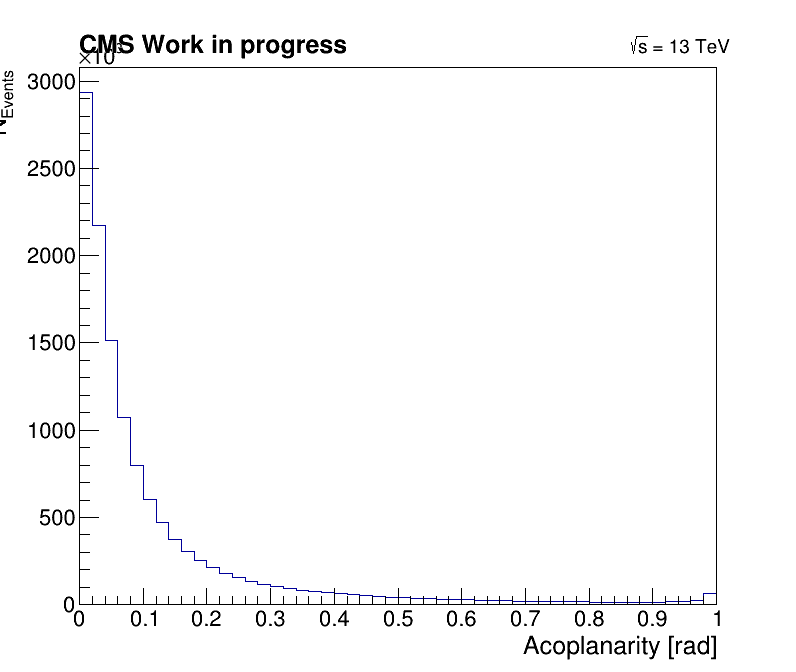

In [39]:
# Produce plots
from Helpers import *
c=PlotMe(h_acopl)
c.Draw()
c.SaveAs("dimuon_acoplanarity.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file dimuon_spectrum.pdf has been created


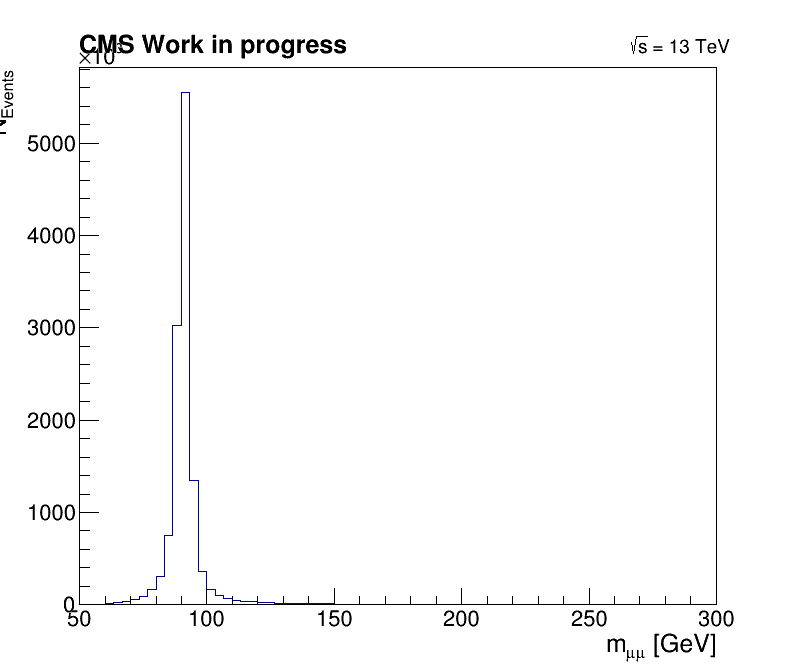

In [40]:
# Produce plots - invariant mass
c=PlotMe(h_mll)
c.Draw()
c.SaveAs("dimuon_spectrum.pdf")

In [ ]:
# Produce plots
c=PlotMe(h_xi0)
c.Draw()
c.SaveAs("correlation_positive_arm.pdf")

In [ ]:
# Produce plots
c=PlotMe(h_xi1)
c.Draw()
c.SaveAs("correlation_negative_arm.pdf")

In [ ]:
 # Produce plots
c=PlotMe(h_xi1_2D,'colz')
# c.Draw('colz') 
line=ROOT.TF1('line','x',0,0.2)
line.SetLineWidth(3); line.Draw('sames')
c.SaveAs("correlation_negative_arm_2D.pdf")

In [ ]:
%%bash
mv results results-${analysis_num}-seconditeration
mkdir -p results